In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2 
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3 
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv3_t = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 3
        self.conv2_t = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 2
        self.conv1_t = nn.Conv2d(16, 1, 3, 1, 1) # Decoder - 1
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.bn32((F.relu(self.conv2(out))))
        out = self.bn64(F.relu(self.conv3(out)))
        out = self.upsample(self.bn32(F.relu(self.conv3_t(out))))
        out = self.upsample(self.bn16(F.relu(self.conv2_t(out))))
        return self.upsample((F.relu(self.conv1_t(out))))

In [49]:
files = ['lena', 'saturn']
MAX_EPOCHS = 500
maps = {}
for file in files:
    im = imread('../data/denoising/{}.png'.format(file))
    noise = imread('../data/denoising/{}-noisy.png'.format(file))
    noisy_img = torch.FloatTensor(noise).unsqueeze(0).unsqueeze(0).transpose(2, 3)
    clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
    
    training_loss, testing_loss = np.zeros((MAX_EPOCHS+1,)), np.zeros((MAX_EPOCHS+1,))
    net = EncDec()
    criterion, optimizer = nn.MSELoss(), optim.Adam(net.parameters(), lr=0.01)
    eta = torch.randn(*noisy_img.size())
    
    for itr in range(MAX_EPOCHS+1):
        out = net(eta)
        optimizer.zero_grad()
        loss = criterion(out, noisy_img)
        loss.backward()
        optimizer.step()
        
        op_img = net(eta)[0, 0, :, :].transpose(0,1).detach().numpy()
        training_loss[itr] = ((noise - op_img)**2).sum()
        testing_loss[itr] = ((im - op_img)**2).sum()
        
        if itr %100 == 0:
            print ("Loss = %.4f, Loss2 %.4f" % (training_loss[itr], testing_loss[itr]))
    maps['%s_train'%file], maps['%s_test'%file] = training_loss, testing_loss
    maps['%s_model'%file] = net
    maps['%s_eta'%file] = eta

Loss = 19892.8004, Loss2 19562.9821
Loss = 715.6447, Loss2 395.9240
Loss = 602.3293, Loss2 292.0056
Loss = 528.3883, Loss2 223.5866
Loss = 506.4037, Loss2 206.1243
Loss = 479.6591, Loss2 185.7527
Loss = 466.2869, Loss2 176.6963
Loss = 455.2916, Loss2 169.8540
Loss = 464.0137, Loss2 181.9947
Loss = 430.0675, Loss2 151.4041
Loss = 433.0270, Loss2 158.7812
Loss = 10442.6462, Loss2 10749.2560
Loss = 485.6958, Loss2 162.0581
Loss = 429.4544, Loss2 125.4496
Loss = 400.6377, Loss2 113.9658
Loss = 404.0512, Loss2 113.9348
Loss = 374.0940, Loss2 104.5408
Loss = 355.2239, Loss2 117.6763
Loss = 343.3959, Loss2 105.0290
Loss = 337.1453, Loss2 110.2927
Loss = 330.0608, Loss2 117.0468
Loss = 319.0521, Loss2 115.0359


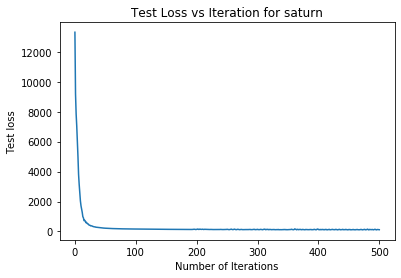

In [33]:
# max_itr = 500
# for file in files:
#     for mode in ['train', 'test']:
#         plt.clf()
#         plt.plot(maps['{}_{}'.format(file, mode)])
#         plt.xlabel('Number of Iterations')
#         plt.ylabel('%s loss' % mode.capitalize())
#         plt.title('%s Loss vs Iteration for %s' % (mode.capitalize(), file))
#         plt.savefig('../data/output/denoise/{}_{}_{}'.format(file, mode, max_itr))

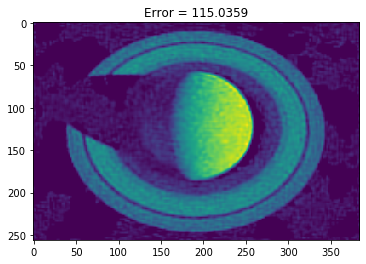

In [56]:
file = 'saturn'
net = maps['%s_model' % file]
eta = maps['%s_eta' % file]
im = imread('../data/denoising/{}.png'.format(file))
out_img = net(eta)[0, 0, :, :].transpose(0,1).detach().numpy()
curr_error = ((im - out_img)**2).sum()
plt.title('Error = %.4f' % curr_error )
plt.imshow(out_img)
plt.savefig('../data/output/denoise/{}_500'.format(file))

In [53]:
np.min(maps['saturn_test'])

99.04157673905037